# Dataset analysis 

In [136]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
import os.path
import re
import matplotlib.pyplot as plt
from typing import List
import seaborn as sns

import tikzplotlib

plt.style.use("seaborn")
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [137]:
base_path = os.path.abspath('.')
graphs_path = os.path.join(base_path, 'Analysis_graphs')
graphs_path = os.path.join(os.path.abspath('..') , 'text', 'automated_graphs')
tables_path = os.path.join(os.path.abspath('..') , 'text', 'tables')

In [138]:
def resampler(image : sitk.SimpleITK.Image, new_spacing : List[float] = None):
    """resampler to isotropic spacing

    Args:
        image (sitk.SimpleITK.Image): image to resample
        new_spacing (List[float], optional): List of three floats representing the new desired spacing. Defaults to None.

    Returns:
        sitk.SimpleITK.Image: resampled image on the new grid
    """
    
    if new_spacing is None:
        new_spacing = [1, 1, 1]

    resampler = sitk.ResampleImageFilter()
    # Nearest neighbour interpolation to avoid disturbing the labels
    # Todo: Adapt this for non-label images
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetOutputSpacing(new_spacing)

    orig_size = np.array(image.GetSize(), dtype=np.int)
    orig_spacing = image.GetSpacing()
    new_size = np.array([x * (y / z) for x, y, z in zip(orig_size, orig_spacing, new_spacing)])
    new_size = np.ceil(new_size).astype(np.int)  # Image dimensions are in integers
    new_size = [int(s) for s in new_size]
    resampler.SetSize(new_size)

    isotropic_img = resampler.Execute(image)

    return isotropic_img

NUMPY_DIMS = {'z' : 0, 'y' : 1, 'x' : 2}
def plot_slice(itkimage : sitk.SimpleITK.Image, axis = 'z', s = 100):
    # When converting from SimpleITK to Numpy, the order of the axis changes:
    #    SimpleITK : xyz 
    #    Numpy:      zyx
    dim = NUMPY_DIMS[axis.lower()]
    
    # resample the image on a 1 mm ✕ 1 mm ✕ 1 mm grid
    arr = sitk.GetArrayFromImage(resampler(itkimage, new_spacing = [1]*3))
    print(f'SimpleITK image size : {itkimage.GetSize()} and the numpy array : {arr.shape}')
    fig = plt.figure()
    plt.imshow(arr.take(indices = s, axis = dim), cmap='gray')
    plt.grid(False)
    return fig

In [139]:
df_all = pd.DataFrame(columns=['Dataset', 
                               'Imaging_technology', 
                               'Age', 
                               'Gender', 
                               'Anteroposterior', 
                               'Craniocaudal', 
                               'Left_right'])

## xVerSeg dataset

[link](http://lit.fe.uni-lj.si/xVertSeg/database.php)

references:

* doi:10.1109/TMI.2013.2296976
* doi:10.1109/TMI.2015.2389334




| Release date | Dataformat | number of scans |
|:-----|----------:|----------|
| OCT 5, 2015  | mhd        | 25              | 



In [140]:
data_folder = os.path.join(base_path, 'xVertSeg')
metadata_file = os.path.join(data_folder, 'metadata.csv')
metadata = pd.read_csv(metadata_file, sep=',', index_col=0)
metadata['x_dim'] = metadata.X * metadata.ΔX
metadata['y_dim'] = metadata.Y * metadata.ΔY
metadata['z_dim'] = metadata.Z * metadata.ΔZ

In [141]:
title = 'xVertSeg dataset\n'

In [142]:
metadata.head()

,Name,Group,Precision(bits),X,Y,Z,ΔX,ΔY,ΔZ,Gender,Age,x_dim,y_dim,z_dim
ID,,,,,,,,,,,,,,
1,image001,Data1,16,1024,1204,200,0.41362,0.41362,1.4506,F,69,423.54688,497.99848,290.1200
2,image002,Data1,16,1024,1024,250,0.43207,0.43207,1.2895,F,40,442.43968,442.43968,322.3750
3,image003,Data1,16,1024,1024,340,0.54070,0.54070,1.1924,F,60,553.67680,553.67680,405.4160
4,image004,Data1,16,1024,1024,170,0.42254,0.42254,1.2837,F,78,432.68096,432.68096,218.2290
5,image005,Data1,16,1024,1024,181,0.49629,0.49629,1.8919,M,77,508.20096,508.20096,342.4339


In [143]:
xVertSeg_meta = metadata[metadata.Group == 'Data1']

Gender
F    8
M    7
Name: Name, dtype: int64


<Figure size 288x576 with 0 Axes>

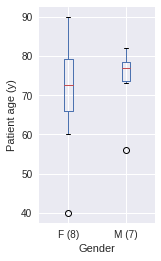

In [144]:
print(xVertSeg_meta.groupby('Gender').count()['Name'])
plt.figure(figsize=(4, 8))
xVertSeg_meta.boxplot(by='Gender', column='Age', figsize=(2, 4))
plt.ylabel('Patient age (y)')
plt.xticks([1, 2], ['F (8)', 'M (7)'])
plt.title('')
#plt.suptitle(title + 'age distribution')
plt.suptitle('')

tikzplotlib.save(os.path.join(graphs_path,'xVertSeg_ageboxplot.tex'), axis_width ='5cm', axis_height ='6cm')

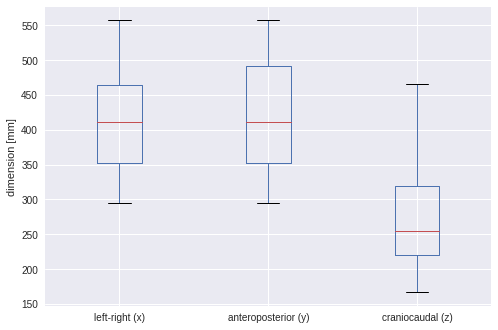

In [145]:
xVertSeg_meta[['x_dim', 'y_dim', 'z_dim']].plot(kind = 'box')
plt.ylabel('dimension [mm]')
plt.xticks([1, 2, 3], ['left-right (x)', 'anteroposterior (y)', 'craniocaudal (z)'])
#plt.title('Distribution of the xVertSeg volume dimensions')
tikzplotlib.save(os.path.join(graphs_path,'xVertSeg_dimensionboxplot.tex'), axis_width ='10cm', axis_height ='7cm')

Todo: Investigate very short sample further!

SimpleITK image size : (1024, 1024, 250) and the numpy array : (323, 443, 443)


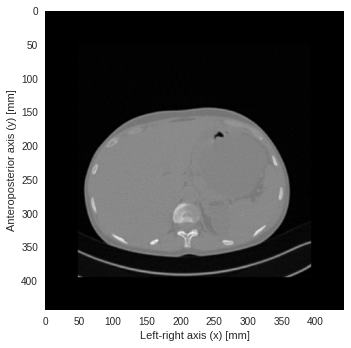

In [146]:
image_name = os.path.join(data_folder, 'Data1', 'images', 'image002.mhd')
itkimage = sitk.ReadImage(image_name)

plot_slice(itkimage, axis = 'z', s = 110)
plt.xlabel('Left-right axis (x) [mm]')
plt.ylabel('Anteroposterior axis (y) [mm]')
plt.savefig(os.path.join(graphs_path,'xVertSeg_image002_TransverseSlice.png'))

SimpleITK image size : (1024, 1024, 250) and the numpy array : (323, 443, 443)


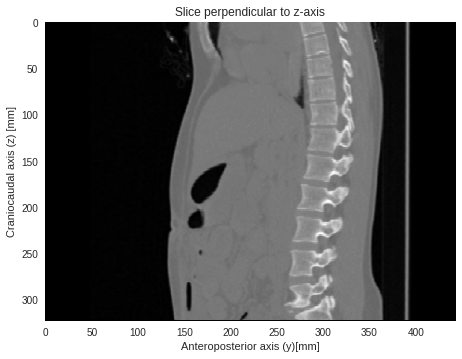

In [147]:
plot_slice(itkimage, axis = 'x', s = 200)
plt.xlabel('Anteroposterior axis (y)[mm]')
plt.ylabel('Craniocaudal axis (z) [mm]')
plt.title('Slice perpendicular to z-axis')
plt.savefig(os.path.join(graphs_path,'xVertSeg_image002_SagittalSlice.png'))

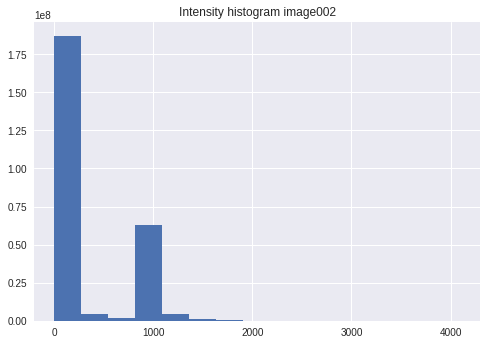

In [148]:
plt.hist(sitk.GetArrayFromImage(itkimage).flatten(), bins = 15) 
plt.title("Intensity histogram image002") 
tikzplotlib.save(os.path.join(graphs_path,'xVertSeg_image002_intensityhistogram.tex'))

Conclusion: For the xVerSeg dataset:

 * x = Left-right axis  
 * y = Anteroposterior axis  
 * z = Craniocaudam axis

In [149]:
scores_file = os.path.join(data_folder, 'Data1', 'scores', 'scores.csv')
scores = pd.read_csv(scores_file, header=1)
cases = {0:'normal',1:'wedge', 2:'biconcave', 3:'crush'}
grad = {0:'normal', 1:'mild', 2:'moderate', 3:'severe'}
scores = scores.replace({f'L{i} case' : cases for i in [1,2,3,4,5]} )
scores = scores.replace({f'L{i} grade' : grad for i in [1,2,3,4,5]})
scores.set_index('Spine image').transpose().to_latex(os.path.join(tables_path,'xVertSeg_pathologies.tex'), index=True)
scores.head()

,Spine image,L1 grade,L1 case,L2 grade,L2 case,L3 grade,L3 case,L4 grade,L4 case,L5 grade,L5 case
0,image001,mild,crush,normal,normal,mild,wedge,mild,wedge,mild,crush
1,image002,normal,normal,normal,normal,normal,normal,mild,wedge,normal,normal
2,image003,mild,biconcave,mild,biconcave,mild,biconcave,mild,biconcave,mild,crush
3,image004,normal,normal,normal,normal,mild,crush,mild,crush,mild,wedge
4,image005,mild,biconcave,mild,biconcave,normal,normal,mild,wedge,normal,normal


In [150]:
counts = pd.DataFrame()
for i in [1,2,3,4,5]:
    counts[f'L{i}'] = scores[f'L{i} case'].value_counts().astype(int)

In [151]:
counts = counts.fillna(0).astype(int)
counts['Total'] = counts.sum(axis=1)
counts.to_latex(os.path.join(tables_path,'xVertSeg_pathologies_summary.tex'), index=True)
counts

,L1,L2,L3,L4,L5,Total
biconcave,6,7,8,4,2,27
normal,5,6,4,4,7,26
wedge,3,2,2,3,2,12
crush,1,0,1,4,4,10


In [152]:
metadata.columns

Index(['Name', 'Group', 'Precision(bits)', 'X', 'Y', 'Z', 'ΔX', 'ΔY', 'ΔZ',
       'Gender', 'Age', 'x_dim', 'y_dim', 'z_dim'],
      dtype='object')

In [153]:
metadata['Dataset'] = 'xVertSeg'
metadata['Imaging_technology'] = 'CT'


df_all = df_all.append(metadata[['x_dim', 
                                 'y_dim', 
                                 'z_dim', 
                                 'Dataset', 
                                 'Age', 
                                 'Gender',
                                'Imaging_technology']].rename(columns = {'x_dim' : 'Left_right',
                                                   'y_dim' : 'Anteroposterior',
                                                   'z_dim' : 'Craniocaudal'}))

## USiegen

doi.org/10.1111/cgf.12343]

In [154]:
data_folder = os.path.join(base_path, 'USiegen')
title = 'USiegen dataset\n'

In [155]:
metadata_file = os.path.join(data_folder, 'metadata.csv')
USiegen_meta = pd.read_csv(metadata_file, sep=',').rename(columns={"Sex": "Gender"})
USiegen_meta['Dataset'] = USiegen_meta['Dataset'].str.encode('utf-8').astype('string')
USiegen_meta['Dataset'] = USiegen_meta.Dataset.apply(lambda x : x.split("\'")[1])
USiegen_meta['Gender'] = USiegen_meta.Gender.astype('category')

SimpleITK image size : (512, 512, 15) and the numpy array : (60, 360, 360)


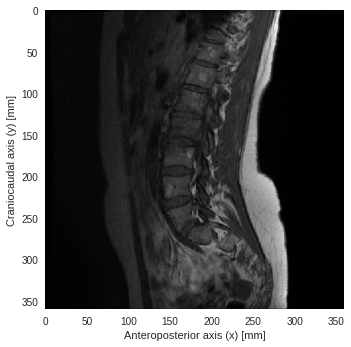

In [156]:
image_name = os.path.join(data_folder, 'SpineDatasets', 'AKa3.dcm')
itkimage = sitk.ReadImage(image_name)

plot_slice(itkimage, axis = 'z', s = 40)
plt.xlabel('Anteroposterior axis (x) [mm]')
plt.ylabel('Craniocaudal axis (y) [mm]')
plt.savefig(os.path.join(graphs_path,'USiegen_Aka3_SagitalSlice.eps'))

SimpleITK image size : (512, 512, 15) and the numpy array : (60, 360, 360)


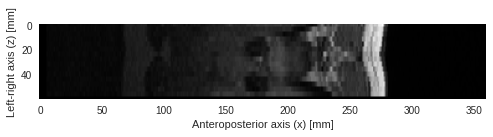

In [157]:
plot_slice(itkimage, axis = 'y', s = 40)
plt.xlabel('Anteroposterior axis (x) [mm]')
plt.ylabel('Left-right axis (z) [mm]')
plt.savefig(os.path.join(graphs_path,'USiegen_Aka3_TransversalSlice.eps'))

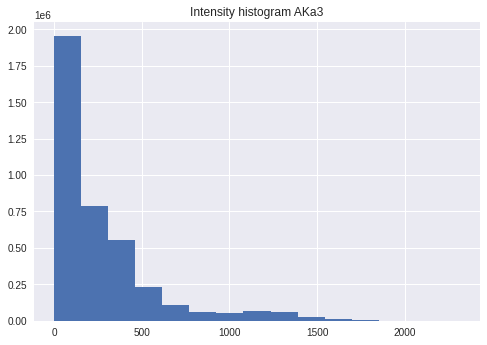

In [158]:
plt.hist(sitk.GetArrayFromImage(itkimage).flatten(), bins = 15) 
plt.title("Intensity histogram AKa3") 
tikzplotlib.save(os.path.join(graphs_path,'USiegen_AKa3_intensityhistogram.tex'))

Conclusion: For the USiegen dataset:

 * x = Anteroposterior axis  
 * y = Craniocaudal axis
 * z = Left-right axis

In [159]:
spines = os.path.join(data_folder, 'SpineDatasets')

ls_name = []
ls_x = []
ls_y = []
ls_z = []

ls_Δx = []
ls_Δy = []
ls_Δz = []

for file in os.listdir(spines):
    itkimage = sitk.ReadImage(os.path.join(spines, file))
    # print(f'file : {file} - size : {itkimage.GetSize()} - spacing : {itkimage.GetSpacing()}')
    ls_name.append(file.split('.')[0])
    x, y, z = itkimage.GetSize()
    Δx, Δy, Δz = itkimage.GetSpacing()
    ls_x.append(x)
    ls_y.append(y)
    ls_z.append(z)
    ls_Δx.append(Δx)
    ls_Δy.append(Δy)
    ls_Δz.append(Δz)
    
USiegen_sizes = pd.DataFrame(data={
    'Dataset' : ls_name,
    'X':ls_x,
    'Y':ls_y,
    'Z':ls_z,
    'ΔX':ls_Δx,
    'ΔY':ls_Δy,
    'ΔZ':ls_Δz
})

USiegen_sizes['Dataset'] = USiegen_sizes['Dataset'].str.encode('utf-8').astype('string')

USiegen_sizes['Dataset'] = USiegen_sizes.Dataset.apply(lambda x : x.split("\'")[1])

In [160]:
USiegen_meta = USiegen_sizes.set_index('Dataset').join(USiegen_meta.set_index('Dataset'))

USiegen_meta['x_dim'] = USiegen_meta.X * USiegen_meta.ΔX
USiegen_meta['y_dim'] = USiegen_meta.Y * USiegen_meta.ΔY
USiegen_meta['z_dim'] = USiegen_meta.Z * USiegen_meta.ΔZ

USiegen_meta.head()

,X,Y,Z,ΔX,ΔY,ΔZ,MRI Seq.,Gender,Age,Path.,SB,Station,x_dim,y_dim,z_dim
Dataset,,,,,,,,,,,,,,,
St1,704,704,20,0.500000,0.500000,3.850001,T 2 SE,M,71,St,NS,Prague2,352.000000,352.000000,77.000017
AKs6,512,512,15,0.703100,0.703100,4.000000,T 1 FSE,F,22,+,EU,Sarajevo,359.987200,359.987200,60.000000
F03,320,320,25,1.187500,1.187500,3.300000,T 2 TSE,M,72,VF,NS,Prague1,380.000000,380.000000,82.500011
C002,448,448,31,1.116071,1.116071,3.300000,T 2 TSE,F,74,Sco,NS,Prague1,500.000014,500.000014,102.300003
AKa2,512,512,15,0.703100,0.703100,4.000000,T 2 frFSE,F,21,+,EU,Sarajevo,359.987200,359.987200,60.000000


Gender
F    11
M     6
Name: SB, dtype: int64


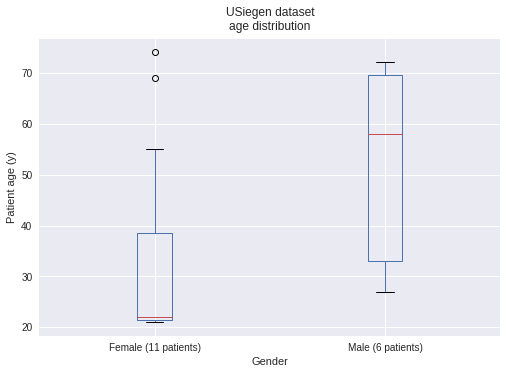

In [161]:
print(USiegen_meta.groupby('Gender').count()['SB'])
USiegen_meta.boxplot(by='Gender', column='Age')
plt.ylabel('Patient age (y)')
plt.xticks([1, 2], ['Female (11 patients)', 'Male (6 patients)'])
plt.title('')
plt.suptitle(title + 'age distribution')

tikzplotlib.save(os.path.join(graphs_path,'USiegen_ageboxplot.tex'))

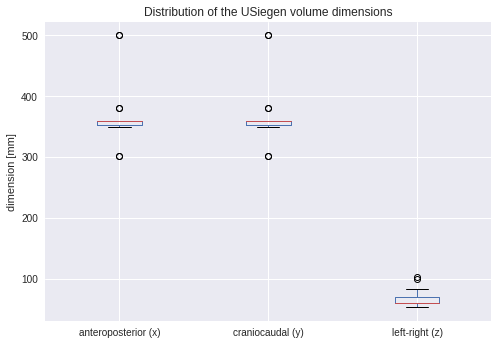

In [162]:
USiegen_meta[['x_dim', 'y_dim', 'z_dim']].plot(kind = 'box')
plt.ylabel('dimension [mm]')
plt.xticks([1, 2, 3], ['anteroposterior (x)', 'craniocaudal (y)', 'left-right (z)'])
plt.title('Distribution of the USiegen volume dimensions')
tikzplotlib.save(os.path.join(graphs_path,'USiegen_dimensionboxplot.tex'))

Conclusion: For the USiegen dataset:

 * x = Anteroposterior axis  
 * y = Craniocaudal axis
 * z = Left-right axis

In [163]:
metadata = USiegen_meta
metadata['Dataset'] = 'USiegen'
metadata['Imaging_technology'] = 'CT'

df_all = df_all.append(metadata[['x_dim', 
                                 'y_dim', 
                                 'z_dim', 
                                 'Dataset', 
                                 'Age', 
                                 'Gender',
                                'Imaging_technology']].rename(columns = {'z_dim' : 'Left_right',
                                                   'x_dim' : 'Anteroposterior',
                                                   'y_dim' : 'Craniocaudal'}))

## MyoSegment_TUM
OSF Sara Schlaeger

    DOI: 10.1186/s12891-019-2528-x

In [164]:
data_folder = os.path.join(base_path, 'OSF_Sarah_Schlaeger')
title = 'OSF dataset\n'

In [165]:
OSF_meta = pd.read_excel(os.path.join(data_folder, 'Table1.xlsx'))
OSF_meta = OSF_meta.rename(columns = {'sex' : 'Gender', 'age [y]' : 'Age', 'height[m]':'Height'
                                      , 'BMI [kg/m^2]' : 'BMI', 'weight [kg]' : 'Weight', 'ID' : 'Dataset'})

sex_encode = {'female' : 'F', 'male' : 'M'}
OSF_meta = OSF_meta = OSF_meta.replace({'Gender' : sex_encode} )
OSF_meta['Gender'] = OSF_meta['Gender'].astype('category')

In [166]:
OSF_meta.head()

,Dataset,Gender,Age,Height,Weight,BMI,PDFF erector spinae muscle left [%],PDFF erector spinae muscle right [%],PDFF psoas muscle left [%],PDFF psoas muscle right [%],PDFF L1,PDFF L2,PDFF L3,PDFF L4,PDFF L5
0,1,F,39.0,1.64,69.0,25.654372,8.030084,10.343813,2.946727,2.697653,22.675208,22.292180,22.370347,23.575756,23.835232
1,2,F,25.0,1.69,75.0,26.259585,11.158456,9.087643,2.813373,1.546058,21.623947,22.099343,23.993207,24.362691,25.589741
2,3,M,31.0,1.88,87.0,24.615211,5.783716,7.914512,4.753319,2.276153,18.575736,18.192894,17.720026,20.771632,19.930568
3,4,M,41.0,1.75,79.0,25.795918,7.758009,8.868839,5.386247,3.577872,23.920297,26.485142,26.657317,27.769132,27.506649
4,5,M,28.0,1.71,73.0,24.964946,10.573860,9.185883,4.143663,2.072042,25.476541,26.076199,26.451735,27.732905,30.411607


Gender
F    39
M    15
Name: Dataset, dtype: int64


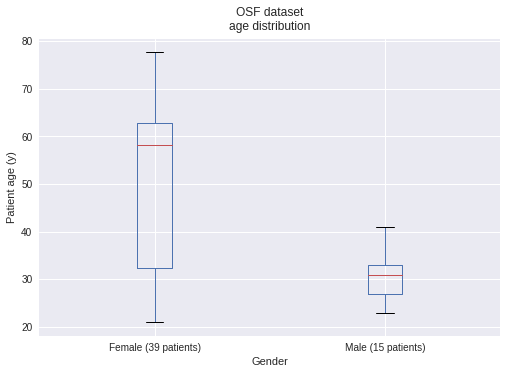

In [167]:
print(OSF_meta.groupby('Gender').count()['Dataset'])
OSF_meta.boxplot(by='Gender', column='Age')
plt.ylabel('Patient age (y)')
plt.xticks([1, 2], ['Female (39 patients)', 'Male (15 patients)'])
plt.title('')
plt.suptitle(title + 'age distribution')

tikzplotlib.save(os.path.join(graphs_path,'OSF_ageboxplot.tex'))

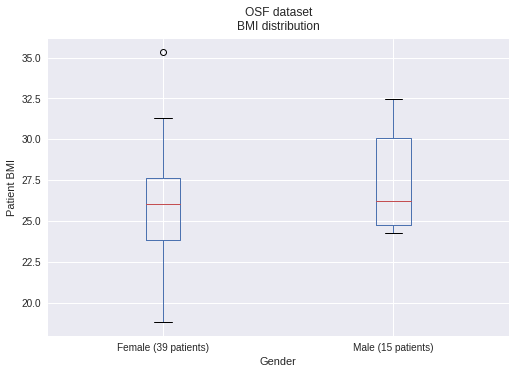

In [168]:
OSF_meta.boxplot(by='Gender', column='BMI')
plt.ylabel('Patient BMI')
plt.xticks([1, 2], ['Female (39 patients)', 'Male (15 patients)'])
plt.title('')
plt.suptitle(title + 'BMI distribution')

tikzplotlib.save(os.path.join(graphs_path,'OSF_BMIboxplot.tex'))

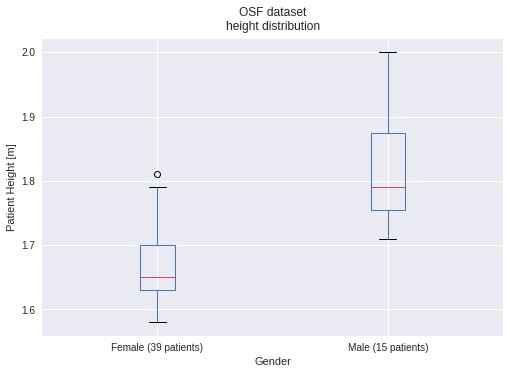

In [169]:
OSF_meta.boxplot(by='Gender', column='Height')
plt.ylabel('Patient Height [m]')
plt.xticks([1, 2], ['Female (39 patients)', 'Male (15 patients)'])
plt.title('')
plt.suptitle(title + 'height distribution')

tikzplotlib.save(os.path.join(graphs_path,'OSF_Heightboxplot.tex'))

SimpleITK image size : (224, 224, 20) and the numpy array : (81, 221, 221)


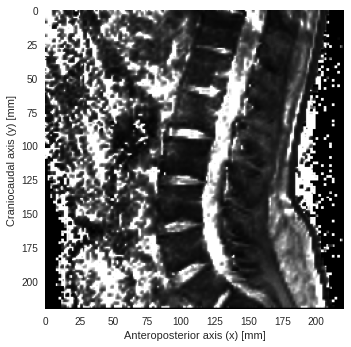

In [170]:
image_name = os.path.join(data_folder, '02', '02', 'vertebrae', 'T2star.dcm')
itkimage = sitk.ReadImage(image_name)

plot_slice(itkimage, axis = 'z', s = 40)
plt.xlabel('Anteroposterior axis (x) [mm]')
plt.ylabel('Craniocaudal axis (y) [mm]')
plt.savefig(os.path.join(graphs_path,'OSF_02_SagitalSlice.eps'))

SimpleITK image size : (224, 224, 20) and the numpy array : (81, 221, 221)


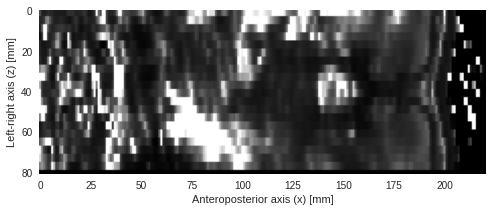

In [171]:
plot_slice(itkimage, axis = 'y', s = 40)
plt.xlabel('Anteroposterior axis (x) [mm]')
plt.ylabel('Left-right axis (z) [mm]')
plt.savefig(os.path.join(graphs_path,'OSF_02_TransversalSlice.eps'))

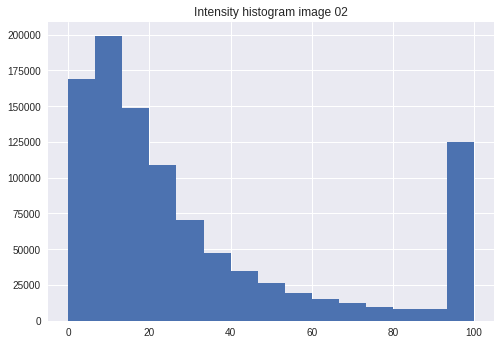

In [172]:
plt.hist(sitk.GetArrayFromImage(itkimage).flatten(), bins = 15) 
plt.title("Intensity histogram image 02") 
tikzplotlib.save(os.path.join(graphs_path,'OSF_02_intensityhistogram.tex'))

In [173]:
ls_name = []
ls_x = []
ls_y = []
ls_z = []

ls_Δx = []
ls_Δy = []
ls_Δz = []

for i in range(1,54):
    file_name = os.path.join(data_folder, f'{i:02d}', f'{i:02d}', 'vertebrae', 'T2star.dcm')
    itkimage = sitk.ReadImage(file_name)
    ls_name.append(i)
    x, y, z = itkimage.GetSize()
    Δx, Δy, Δz = itkimage.GetSpacing()
    ls_x.append(x)
    ls_y.append(y)
    ls_z.append(z)
    ls_Δx.append(Δx)
    ls_Δy.append(Δy)
    ls_Δz.append(Δz)
    
OSF_sizes = pd.DataFrame(data={
    'Dataset' : ls_name,
    'X':ls_x,
    'Y':ls_y,
    'Z':ls_z,
    'ΔX':ls_Δx,
    'ΔY':ls_Δy,
    'ΔZ':ls_Δz
})


In [174]:
OSF_meta = OSF_sizes.set_index('Dataset').join(OSF_meta.set_index('Dataset'))

OSF_meta['x_dim'] = OSF_meta.X * OSF_meta.ΔX
OSF_meta['y_dim'] = OSF_meta.Y * OSF_meta.ΔY
OSF_meta['z_dim'] = OSF_meta.Z * OSF_meta.ΔZ

OSF_meta.head()

,X,Y,Z,ΔX,ΔY,ΔZ,Gender,Age,Height,Weight,...,PDFF psoas muscle left [%],PDFF psoas muscle right [%],PDFF L1,PDFF L2,PDFF L3,PDFF L4,PDFF L5,x_dim,y_dim,z_dim
Dataset,,,,,,,,,,,,,,,,,,,,,
1,224,224,20,0.982143,0.982143,4.000000,F,39.0,1.64,69.0,...,2.946727,2.697653,22.675208,22.292180,22.370347,23.575756,23.835232,220.000002,220.000002,80.000004
2,224,224,20,0.982143,0.982143,4.000000,F,25.0,1.69,75.0,...,2.813373,1.546058,21.623947,22.099343,23.993207,24.362691,25.589741,220.000002,220.000002,80.000000
3,224,224,20,0.982143,0.982143,4.000000,M,31.0,1.88,87.0,...,4.753319,2.276153,18.575736,18.192894,17.720026,20.771632,19.930568,220.000002,220.000002,80.000000
4,224,224,20,0.982143,0.982143,4.000002,M,41.0,1.75,79.0,...,5.386247,3.577872,23.920297,26.485142,26.657317,27.769132,27.506649,220.000002,220.000002,80.000045
5,224,224,20,0.982143,0.982143,3.999998,M,28.0,1.71,73.0,...,4.143663,2.072042,25.476541,26.076199,26.451735,27.732905,30.411607,220.000002,220.000002,79.999964


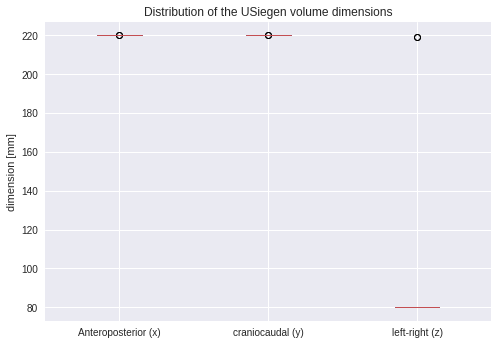

In [175]:
OSF_meta[['x_dim', 'y_dim', 'z_dim']].plot(kind = 'box')
plt.ylabel('dimension [mm]')
plt.xticks([1, 2, 3], ['Anteroposterior (x)', 'craniocaudal (y)', 'left-right (z)'])
plt.title('Distribution of the USiegen volume dimensions')
tikzplotlib.save(os.path.join(graphs_path,'OSF_dimensionboxplot.tex'))

Conclusion: For the USiegen dataset:

 * x = Anteroposterior axis  
 * y = Craniocaudal axis
 * z = Left-right axis

In [176]:
metadata = OSF_meta
metadata['Dataset'] = 'MyoSegment_TUM'
metadata['Imaging_technology'] = 'MRI'

df_all = df_all.append(metadata[['x_dim', 
                                 'y_dim', 
                                 'z_dim', 
                                 'Dataset', 
                                 'Age', 
                                 'Gender',
                                'Imaging_technology']].rename(columns = {'z_dim' : 'Left_right',
                                                   'x_dim' : 'Anteroposterior',
                                                   'y_dim' : 'Craniocaudal'}))

## Zenodo

https://zenodo.org/record/22304#.YE-XE_4o82B

In [177]:
data_folder = os.path.join(base_path, 'Zenodo')

In [178]:
ls_name = []
ls_x = []
ls_y = []
ls_z = []

ls_Δx = []
ls_Δy = []
ls_Δz = []

for i in range(1, 23):
    file_name = os.path.join(data_folder, f'Img_{i:02d}.nii')
    itkimage = sitk.ReadImage(file_name)
    ls_name.append(i)
    x, y, z = itkimage.GetSize()
    Δx, Δy, Δz = itkimage.GetSpacing()
    ls_x.append(x)
    ls_y.append(y)
    ls_z.append(z)
    ls_Δx.append(Δx)
    ls_Δy.append(Δy)
    ls_Δz.append(Δz)

Zenodo_meta = pd.DataFrame(data={
    'Dataset' : ls_name,
    'X':ls_x,
    'Y':ls_y,
    'Z':ls_z,
    'ΔX':ls_Δx,
    'ΔY':ls_Δy,
    'ΔZ':ls_Δz
})

Zenodo_meta['x_dim'] = Zenodo_meta.X * Zenodo_meta.ΔX
Zenodo_meta['y_dim'] = Zenodo_meta.Y * Zenodo_meta.ΔY
Zenodo_meta['z_dim'] = Zenodo_meta.Z * Zenodo_meta.ΔZ

SimpleITK image size : (39, 305, 305) and the numpy array : (382, 382, 78)


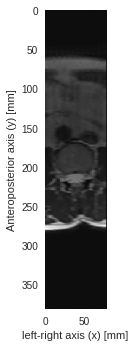

In [179]:
image_name = os.path.join(data_folder, f'Img_02.nii')
itkimage = sitk.ReadImage(image_name)

plot_slice(itkimage, axis = 'z', s = 190)
plt.xlabel('left-right axis (x) [mm]')
plt.ylabel('Anteroposterior axis (y) [mm]')
plt.savefig(os.path.join(graphs_path,'Zenodo_img02_TransverseSlice.eps'))

SimpleITK image size : (39, 305, 305) and the numpy array : (382, 382, 78)


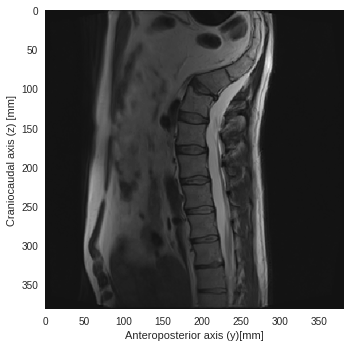

In [180]:
plot_slice(itkimage, axis = 'x', s = 40)
plt.xlabel('Anteroposterior axis (y)[mm]')
plt.ylabel('Craniocaudal axis (z) [mm]')
plt.savefig(os.path.join(graphs_path,'OSF_4564688_TransversalSlice.eps'))

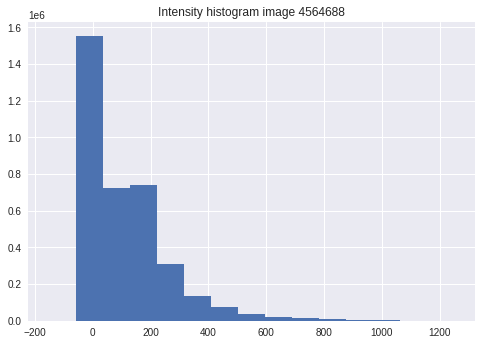

In [181]:
plt.hist(sitk.GetArrayFromImage(itkimage).flatten(), bins = 15) 
plt.title("Intensity histogram image 4564688") 
tikzplotlib.save(os.path.join(graphs_path,'UW_4564688_intensityhistogram.tex'))

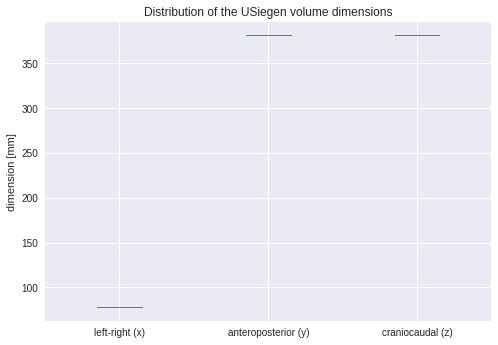

In [182]:
Zenodo_meta[['x_dim', 'y_dim', 'z_dim']].plot(kind = 'box')
plt.ylabel('dimension [mm]')
plt.xticks([1, 2, 3], ['left-right (x)', 'anteroposterior (y)', 'craniocaudal (z)'])
plt.title('Distribution of the USiegen volume dimensions')
tikzplotlib.save(os.path.join(graphs_path,'Zenodo_dimensionboxplot.tex'))

In [183]:
Zenodo_meta.head()

,Dataset,X,Y,Z,ΔX,ΔY,ΔZ,x_dim,y_dim,z_dim
0,1,39,305,305,2.0,1.25,1.25,78.000000,381.25,381.25
1,2,39,305,305,2.0,1.25,1.25,77.999991,381.25,381.25
2,3,39,305,305,2.0,1.25,1.25,77.999991,381.25,381.25
3,4,39,305,305,2.0,1.25,1.25,77.999991,381.25,381.25
4,5,39,305,305,2.0,1.25,1.25,78.000000,381.25,381.25


In [184]:
metadata = Zenodo_meta
metadata['Dataset'] = 'PLoS'
metadata['Imaging_technology'] = 'MRI'
metadata['Age'] = 'Unknown'
metadata['Gender'] = 'Unknown'

df_all = df_all.append(metadata[['x_dim', 
                                 'y_dim', 
                                 'z_dim', 
                                 'Dataset', 
                                 'Age', 
                                 'Gender',
                                'Imaging_technology']].rename(columns = {'x_dim' : 'Left_right',
                                                   'y_dim' : 'Anteroposterior',
                                                   'z_dim' : 'Craniocaudal'}))

## University of Washington

source : 

In [185]:
data_folder = os.path.join(base_path, 'UWSpineCT-selected')

metadata_file = os.path.join(data_folder, 'UWSpineCT-meta-data.xlsx')

In [186]:
UW_meta = pd.read_excel(metadata_file, sheet_name='allSpine-out-DH-orig', header=[0,1])
UW_meta = UW_meta.drop(UW_meta.columns[2], axis=1)
UW_meta

Unnamed: 0_level_0 Unnamed: 1_level_0 Information per Scan             \
            Patient ID            Scan ID       # scans / pat. Gender Age   
0                    1            2804506                    2      F  37   
1                    1            2805012                    2      F  37   
2                    2            4533808                    2      M  57   
3                    2            4533809                    2      M  57   
4                    3            4613319                    2      M  57   
..                 ...                ...                  ...    ...  ..   
237                492            2495831                    2      F  48   
238                496            4574403                    1      M  24   
239                499            4407253                    2      F  42   
240                499            4407254                    2      F  42   
241                501            4565686                    1      M  45   

          Information per Patient               
    Age.1          # scans / pat. Gender   Age  
0     NaN                     2.0      F  37.0  
1     NaN                     NaN    NaN   NaN  
2     NaN                     2.0      M  57.0  
3     NaN                     NaN    NaN   NaN  
4     NaN                     2.0      M  57.0  
..    ...                     ...    ...   ...  
237   NaN                     NaN    NaN   NaN  
238   NaN                     1.0      M  24.0  
239   NaN                     2.0      F  42.0  
240   NaN                     NaN    NaN   NaN  
241   NaN                     1.0      M  45.0  

[242 rows x 9 columns]

In [187]:
UW_meta_patients = UW_meta.iloc[:,[0,1,6,7,8]]
UW_meta_patients = UW_meta_patients.dropna(axis=0)
UW_meta_patients.columns = UW_meta_patients.columns.droplevel(0)
UW_meta_patients.head()

,Patient ID,Scan ID,# scans / pat.,Gender,Age
0,1,2804506,2.0,F,37.0
2,2,4533808,2.0,M,57.0
4,3,4613319,2.0,M,57.0
6,4,4576147,2.0,M,76.0
8,6,4574668,2.0,M,63.0


Gender
F    54
M    71
Name: Patient ID, dtype: int64


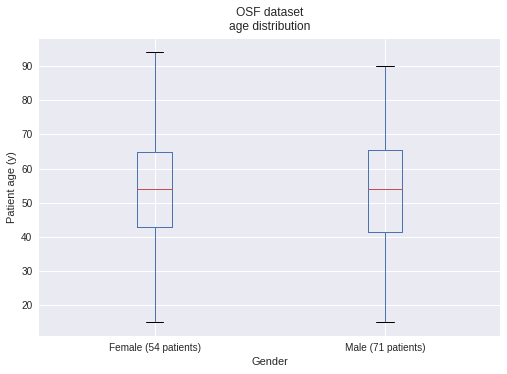

In [188]:
print(UW_meta_patients.groupby('Gender').count()['Patient ID'])
UW_meta_patients.boxplot(by='Gender', column='Age')
plt.ylabel('Patient age (y)')
plt.xticks([1, 2], ['Female (54 patients)', 'Male (71 patients)'])
plt.title('')
plt.suptitle(title + 'age distribution')

tikzplotlib.save(os.path.join(graphs_path,'UW_ageboxplot.tex'))

In [189]:
UW_meta_scans = UW_meta.iloc[:,[0, 1, 2, 3, 4]]
UW_meta_scans.columns = UW_meta_scans.columns.droplevel(0)
UW_meta_scans = UW_meta_scans.rename(columns={'Scan ID' : 'Dataset'})
UW_meta_scans.shape

(242, 5)

In [190]:
print(
    'University of Washington dataset contains {} scans of {} different patients'.format(UW_meta_scans.shape[0], UW_meta_scans['Patient ID'].nunique())
)

University of Washington dataset contains 242 scans of 125 different patients


In [191]:
file_paths = list()
for f in os.walk(data_folder):
    folder = f[0]
    files = f[2]
    for file in files:
        if file.endswith('.nii.gz') and 'spine-test-data' not in folder:
            file_paths.append(
                os.path.join(folder, file)
            )

ls_name = []
ls_x = []
ls_y = []
ls_z = []

ls_Δx = []
ls_Δy = []
ls_Δz = []

get_ID = re.compile(r'(\d+).nii.gz$')

for file_name in file_paths:
    itkimage = sitk.ReadImage(file_name)
    # print(int(get_ID.findall(file_name)[0]))
    ls_name.append(int(get_ID.findall(file_name)[0]))
    x, y, z = itkimage.GetSize()
    Δx, Δy, Δz = itkimage.GetSpacing()
    ls_x.append(x)
    ls_y.append(y)
    ls_z.append(z)
    ls_Δx.append(Δx)
    ls_Δy.append(Δy)
    ls_Δz.append(Δz)

UW_meta2 = pd.DataFrame(data={
    'Dataset' : ls_name,
    'X':ls_x,
    'Y':ls_y,
    'Z':ls_z,
    'ΔX':ls_Δx,
    'ΔY':ls_Δy,
    'ΔZ':ls_Δz
})

UW_meta2['x_dim'] = UW_meta2.X * UW_meta2.ΔX
UW_meta2['y_dim'] = UW_meta2.Y * UW_meta2.ΔY
UW_meta2['z_dim'] = UW_meta2.Z * UW_meta2.ΔZ

UW_meta_scans = UW_meta_scans.set_index('Dataset').join(UW_meta2.set_index('Dataset'))

/home/jan/Documents/Projects/MastatThesis/Data/UWSpineCT-selected/spine-3/patient0265/4564688/4564688.nii.gz
SimpleITK image size : (512, 512, 182) and the numpy array : (228, 141, 141)


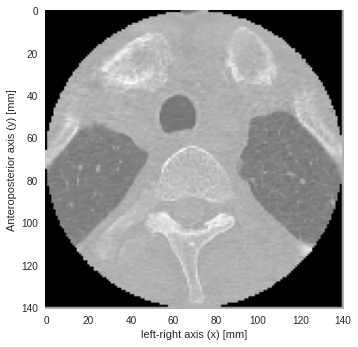

In [192]:
print(file_paths[3])

image_name = file_paths[3]
itkimage = sitk.ReadImage(image_name)

plot_slice(itkimage, axis = 'z', s = 40)
plt.xlabel('left-right axis (x) [mm]')
plt.ylabel('Anteroposterior axis (y) [mm]')
plt.savefig(os.path.join(graphs_path,'UW_4564688_TransverseSlice.eps'))

SimpleITK image size : (512, 512, 182) and the numpy array : (228, 141, 141)


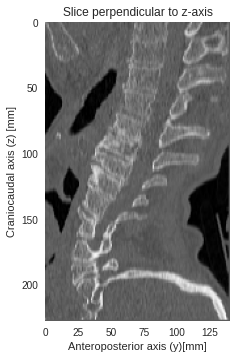

In [193]:
plot_slice(itkimage, axis = 'x', s = 70)
plt.xlabel('Anteroposterior axis (y)[mm]')
plt.ylabel('Craniocaudal axis (z) [mm]')
plt.title('Slice perpendicular to z-axis')
plt.savefig(os.path.join(graphs_path,'OSF_4564688_TransversalSlice.eps'))

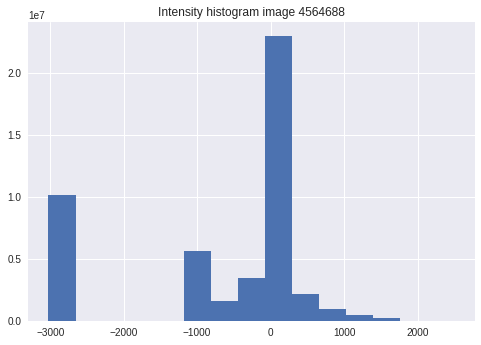

In [194]:
plt.hist(sitk.GetArrayFromImage(itkimage).flatten(), bins = 15) 
plt.title("Intensity histogram image 4564688") 
tikzplotlib.save(os.path.join(graphs_path,'UW_4564688_intensityhistogram.tex'))

Conclusion: For the xVerSeg dataset:

 * x = Left-right axis  
 * y = Anteroposterior axis  
 * z = Craniocaudal axis

In [195]:
UW_meta_scans

,Patient ID,# scans / pat.,Gender,Age,X,Y,Z,ΔX,ΔY,ΔZ,x_dim,y_dim,z_dim
Dataset,,,,,,,,,,,,,
2804506,1,2,F,37,512,512,103,0.312500,0.312500,2.50,160.000000,160.000000,257.5
2805012,1,2,F,37,512,512,115,0.347656,0.347656,2.50,177.999878,177.999878,287.5
4533808,2,2,M,57,512,512,210,0.273438,0.273438,1.25,140.000259,140.000259,262.5
4533809,2,2,M,57,512,512,231,0.351562,0.351562,2.50,179.999741,179.999741,577.5
4613319,3,2,M,57,512,512,214,0.291016,0.291016,1.25,149.000198,149.000198,267.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495831,492,2,F,48,512,512,117,0.332031,0.332031,2.50,169.999878,169.999878,292.5
4574403,496,1,M,24,512,512,95,0.382812,0.382812,2.50,195.999741,195.999741,237.5
4407253,499,2,F,42,512,512,70,0.246094,0.246094,2.50,126.000130,126.000130,175.0


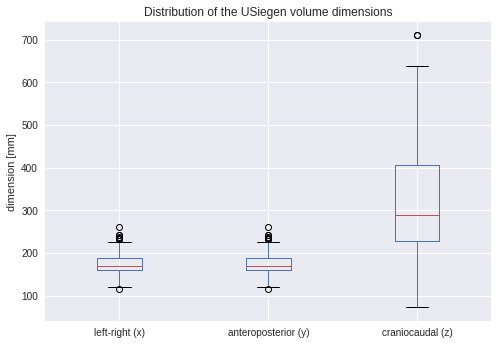

In [196]:
UW_meta_scans[['x_dim', 'y_dim', 'z_dim']].plot(kind = 'box')
plt.ylabel('dimension [mm]')
plt.xticks([1, 2, 3], ['left-right (x)', 'anteroposterior (y)', 'craniocaudal (z)'])
plt.title('Distribution of the USiegen volume dimensions')
tikzplotlib.save(os.path.join(graphs_path,'UW_dimensionboxplot.tex'))

In [197]:
UW_meta_scans['Patient ID'] = UW_meta_scans['Patient ID'].astype('int16')
UW_meta_patients['Patient ID'] = UW_meta_patients['Patient ID'].astype('int16')

metadata = UW_meta_patients[['Gender', 
                          'Age', 
                          'Patient ID']].set_index('Patient ID').join(UW_meta_scans[['Patient ID',
                                                            'x_dim', 'y_dim', 'z_dim']].set_index('Patient ID'), 
                                              how='left',  lsuffix='patients', rsuffix='scans')

metadata['Dataset'] = 'UWashington'
metadata['Imaging_technology'] = 'CT'


df_all = df_all.append(metadata[['x_dim', 
                                 'y_dim', 
                                 'z_dim', 
                                 'Dataset', 
                                 'Age', 
                                 'Gender',
                                'Imaging_technology']].rename(columns = {'x_dim' : 'Left_right',
                                                   'y_dim' : 'Anteroposterior',
                                                   'z_dim' : 'Craniocaudal'}))

## Overview of all datapoints

In [198]:
df_all['Age'] = df_all['Age'].replace('Unknown', np.nan).astype('int16', errors = 'ignore')
df_all_countGender = df_all.groupby('Gender').agg({'Dataset': 'count'}).rename(columns = {'Dataset' : 'amount'})
df_all_avgAgeGender = df_all.dropna(how='any').groupby('Gender').agg({'Age': 'mean', 'Dataset': 'count'}).rename(columns = {'Age' : 'Average age', 'Dataset' : 'amount'})
df_all_avgAgeDataset = df_all.groupby(['Dataset', 'Gender']).agg({'Age': 'mean', 'Gender': 'count'}).rename(columns = {'Gender' : 'amount'})

datasets = [df_all, df_all_countGender,df_all_avgAgeGender,df_all_avgAgeDataset]
names = ['all', 'countGender', 'avgAgeGender', 'avgAgeDataset']

with pd.ExcelWriter(os.path.join(tables_path,'overview.xlsx')) as writer:
    for df, name in zip(datasets, names):
        df.to_excel(writer, sheet_name=name)
        df.to_latex(os.path.join(tables_path,f'df_all_{name}.tex'))

print(df_all.groupby('Imaging_technology').count()['Dataset'])

Imaging_technology
CT     284
MRI     75
Name: Dataset, dtype: int64


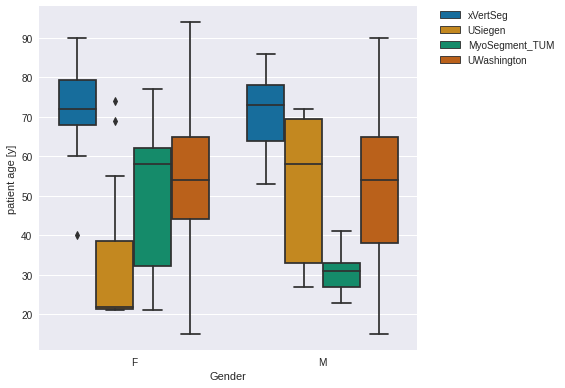

In [199]:
df_all = df_all.replace('Unknown',np.nan)
df_all = df_all.dropna(axis=0, how='any')

df_all['Age'] = df_all['Age'].astype('int16', errors='ignore')
g= sns.boxplot(x='Gender', hue = 'Dataset', y='Age', data=df_all, palette = 'colorblind')
g.set_ylabel("patient age [y]")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig(os.path.join(graphs_path,'AllDatset_ageboxplot.png'))
tikzplotlib.save(os.path.join(graphs_path,'AllDatset_ageboxplot.tex'))

Text(0, 0.5, 'patient age [y]')

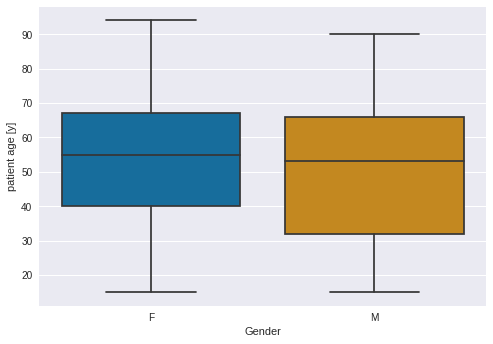

In [200]:
g= sns.boxplot(x='Gender', y='Age', data=df_all, palette = 'colorblind')
g.set_ylabel("patient age [y]")

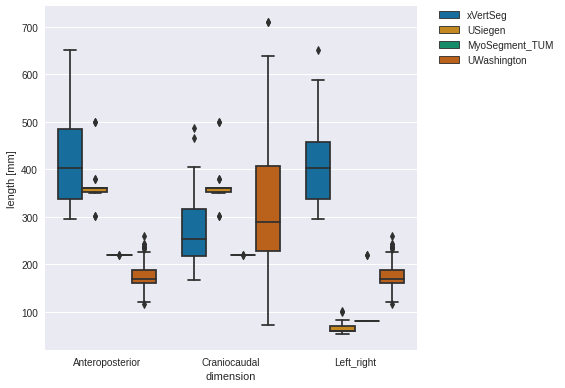

In [201]:
g= sns.boxplot(x='variable', 
               hue = 'Dataset', 
               y='value', 
               data=pd.melt(df_all,
                            id_vars = ['Dataset'], 
                            value_vars=['Anteroposterior', 'Craniocaudal', 'Left_right']),
              palette = 'colorblind')

g.set_ylabel("length [mm]")
g.set_xlabel("dimension")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig(os.path.join(graphs_path,'AllDatset_DimensionsBoxplot.png'))
tikzplotlib.save(os.path.join(graphs_path,'AllDatset_DimensionsBoxplot.tex'))